### Imported libraries

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 15 08:48:42 2024

@author: Youri
"""
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import fmin, minimize
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

### Defined functions

In [2]:
def estimate_error_Buildin_k_inc_Eg(x, E, k_E, N_peaks, weight_E):
# This function estimates the error between the measured data and the fitted data
# Input:
#   x:
#       This vector contains the parameter that describe the k data
#       -S: represents the height of each peak
#       -E_c: represents the location of each peak
#       -W: represents the width of each peak
#       -E_min: represents the minimum energy
#   E:
#       This is the range of energies for which the values are given
#   k_E:
#       This is the k-data which is fitted. It is expressed as a function
#       of energy.
# Output:
#   error:
#       This is the deviation between the measured data and the actual data
#   Written by Y. Blom
    S = np.abs(x[:N_peaks])
    E_c = np.abs(x[N_peaks:2*N_peaks])
    W = np.abs(x[2*N_peaks:3*N_peaks])
    E_min = np.abs(x[-1])
    k_E_fit = Make_k_E_curve(S, E_c, W, E_min, E)
    error = np.sqrt(np.mean((k_E - k_E_fit) * weight_E)**2)
    return error


def Make_k_E_curve(S, E_c, W, E_min, E):
# This function makes a fitted k_E curve based on the fitting parameters
# Input:
#   S:
#       represents the height of each peak
#   E_c:
#       represents the location of each peak
#   W:
#       represents the width of each peak
#   E_min:
#       is the minimum energy that has a nonzero k-values
#   E:
#       This is the range of energies for which the values are given
# Output:
#   k_E_fit:
#       This is the fitted data
#   Written by Y. Blom
    q = 1.60217662e-19
    k_E_fit = np.zeros(len(E))
    for i in range(len(E)):
        if E[i] > E_min * q:
            k_E_fit[i] = np.sum(S * (E[i] / q - E_min)**2 / ((E[i] / q - E_c)**2 + W**2))
            
    return k_E_fit


def KK_integration(wav, k):
#This function applies the KK based on the second method described in:
# [1] K. Ohta et al, Applied Spectroscopy, 42(6), 952-957, (1988).
# Input:
#   wav:
#       The wavelength range of the input data
#   k:
#       The k values
# Output:
#   n_KK:
#       The n data after the KK transformation
# Written by Y. Blom

    # Constants
    h = 6.62607004e-34
    c = 299792458
    
    #The k data is transfered to a function of energy
    E_int = 1e-21
    E = np.arange(h * c / (wav[-1] * 1e-9), h * c / (wav[0] * 1e-9) + E_int, E_int)
    k_E = interp1d(wav * 1e-9, k, kind='linear', fill_value='extrapolate')(h * c / E)
    n_KK_E = np.zeros_like(k_E)
    
    #A numerical integration is done for each wavelength/ energy
    for i in range(len(n_KK_E)):
        #The integral is split into three parts as described by [1]
        j = np.arange(len(n_KK_E))
        j = j[j != i]
        int1 = 2 / np.pi * E_int * np.sum(E[j] * k_E[j] / (E[j]**2 - E[i]**2))
        int2 = 1 / np.pi * E_int * k_E[i] / (2 * E[i])
        if i == 0:
            int3 = 1 / np.pi * E_int * (k_E[i + 1] - k_E[i]) / E_int
        elif i == len(n_KK_E) - 1:
            int3 = 1 / np.pi * E_int * (k_E[i] - k_E[i - 1]) / E_int
        else:
            int3 = 1 / np.pi * E_int * (k_E[i + 1] - k_E[i - 1]) / (2 * E_int)
        n_KK_E[i] = max(1 + int1 + int2 + int3, 0)
    #The data is transferred to a function of wavelength
    n_KK = interp1d(E, n_KK_E, kind='linear', fill_value='extrapolate')(h * c / (wav * 1e-9))
    return n_KK

def error_constant_n(wav, k, n, c):
# This function calculates the error between the integrated n and measured n
# for a certain additional constant c
# Input:
#   wav:
#       The wavelength range of the input data
#   k:
#       The k values
#   n:
#       The n values
#   c:
#       The constant that will be added to the n-data
# Output:
#   error:
#       The difference between the measured and simulated curve
# Written by Y. Blom
    n_test = KK_integration(wav, k)
    error = np.sqrt(np.mean((n_test + c - n)**2))
       
    return error


### Constants

In [3]:
h = 6.62607004e-34
q = 1.60217662e-19
c = 299792458

### User inputs

In [4]:
#This parameter indicates whether the values of the parameters in the FB+ model should be plotted.
plot_param = 1

#This parameter expresses the degree with which the parameter should be fitted (1 = linear, 2 = quadratic, etc.).
deg_fitting = 1

#The filenames of all measured samples and there bandgap energies
name = ["perov_1_557.csv", "perov_1_615.csv", "perov_1_665.csv"]
Eg = np.array([1.557, 1.615, 1.665])

#This parameter indicates how many oscillators are used. 
#Typical values are 2 or 3, which can be observed by visual inspection. 
N_osc = 3

#The bandgap energies for which you want to predict the refractive index
Eg_wanted = np.arange(1.6, 1.7, 0.01)

### Loading files from the folder data

In [5]:
Nsamples = len(Eg)
wav = np.arange(300, 1205, 5)
n_wav = np.zeros((len(wav), Nsamples))
k_wav = np.zeros((len(wav), Nsamples))

#The data is read from the folder
for i in range(Nsamples):
    data = pd.read_csv(os.path.join('Data', name[i]))
    split_data = data["nm;n;k"].str.split(";", expand=True)
    nm_samp = split_data[0].astype(float)
    n_samp = split_data[1].astype(float)
    k_samp = split_data[2].astype(float)
    n_wav[:, i] = interp1d(nm_samp, n_samp, kind='linear', fill_value="extrapolate")(wav)
    k_wav[:, i] = interp1d(nm_samp, k_samp, kind='linear', fill_value="extrapolate")(wav)
    

### Fitting with the FB+ method

In [6]:
#S, E_c, W, n_const, and E_min represent the parameters in the FB+ model.
#For each sample, these parameters are found by fitting the curves. For S,
#E_c, and W, multiple values are needed for each sample, as there are
#multiple oscilators in one material.
S = np.zeros((Nsamples, N_osc))
E_c = np.zeros((Nsamples, N_osc))
W = np.zeros((Nsamples, N_osc))
n_const = np.zeros(Nsamples)
E_min = np.zeros(Nsamples)

Error_k = np.zeros(Nsamples)
Error_n = np.zeros(Nsamples)

#This are the initial guesses for all the parameters.
f_0 = np.array([0.149, 0.078, 0.056])[:N_osc]
E_j_0 = np.array([1.597, 2.418, 3.392])[:N_osc]
gamma_0 = np.array([0.08, 0.387, 0.448])[:N_osc]
Eg_0 = Eg

#An energy axis is made, such that the refractive index can be expressed as
#a function of energy.
E_int = 1e-21
E = np.arange(h * c / (wav[-1] * 1e-9), h * c / (wav[0] * 1e-9), E_int)

#To obtain a higher accuracy in the simulated absorption, some wavelengths
#are more important to predict accurately than others. Therefore, a weight
#is given to the wavelength region 600 nm to 900 nm.
weight_wav = np.ones(len(wav))
weight_ind_min = np.argmin(np.abs(wav - 600))
weight_ind_max = np.argmin(np.abs(wav - 900))
weight_wav[weight_ind_min:weight_ind_max] = 4
weight_E = interp1d(wav * 1e-9, weight_wav)(h * c / E)

#For each sample, the parameters are fitted.
for i in range(Nsamples):
    k_E = interp1d(wav * 1e-9, k_wav[:, i], kind='linear')(h * c / E)
    n_E = interp1d(wav * 1e-9, n_wav[:, i], kind='linear')(h * c / E)
    x0 = np.concatenate((f_0, E_j_0, gamma_0, [Eg_0[i]]))
    
    def fun_k(x):
        return estimate_error_Buildin_k_inc_Eg(x, E, k_E, N_osc, weight_E)

    x = minimize(fun_k, x0, method='Nelder-Mead')
    y = x.x
    S[i, :] = np.abs(y[:N_osc])
    E_c[i, :] = np.abs(y[N_osc:2 * N_osc])
    W[i, :] = np.abs(y[2 * N_osc:3 * N_osc])
    E_min[i] = np.abs(y[-1])
    
    k_E_fitted = Make_k_E_curve(S[i, :], E_c[i, :], W[i, :], E_min[i], E)
    k_fitted = interp1d(E, k_E_fitted, kind='linear', fill_value="extrapolate")(h * c / (wav * 1e-9))

        
    def funmin(x):
        return error_constant_n(wav, k_fitted, n_wav[:, i], x)

    x = minimize(funmin, 0, method='Nelder-Mead')
    n_const[i] = x.x

### Plot the fitted NK data

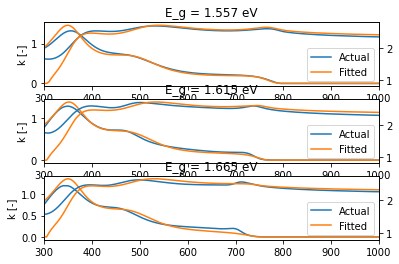

Average fitting error k is 0.03907698450801345
Average fitting error n is 0.14799791605036047


In [7]:
plt.figure()
for i in range(Nsamples):
    if Nsamples == 6 or Nsamples == 5:
        plt.subplot(3, 2, i + 1)
    else:
        plt.subplot(Nsamples, 1, i + 1)
    plt.plot(wav, k_wav[:, i])
    k_E_fitted = Make_k_E_curve(S[i, :], E_c[i, :], W[i, :], E_min[i], E)
    k_wav_fitted = interp1d(E, k_E_fitted, kind='linear', fill_value="extrapolate")(h * c / (wav * 1e-9))
    plt.plot(wav, k_wav_fitted)
    plt.ylabel('k [-]')
    plt.twinx()
    plt.plot(wav, n_wav[:, i])
    n_wav_fitted = KK_integration(wav, k_wav_fitted) + n_const[i]
    plt.plot(wav, n_wav_fitted)
    Error_k[i] = np.sqrt(np.mean((k_wav[:, i] - k_wav_fitted) ** 2))
    Error_n[i] = np.sqrt(np.mean((n_wav[:, i] - n_wav_fitted) ** 2))
    plt.xlim([300, 1000])
    plt.xlabel('Wavelength [nm]')
    plt.title('E_g = {} eV'.format(Eg[i]))
    plt.legend(['Actual', 'Fitted'])

plt.show()

print('Average fitting error k is', np.mean(Error_k))
print('Average fitting error n is', np.mean(Error_n))


### Make the fit of all parameters

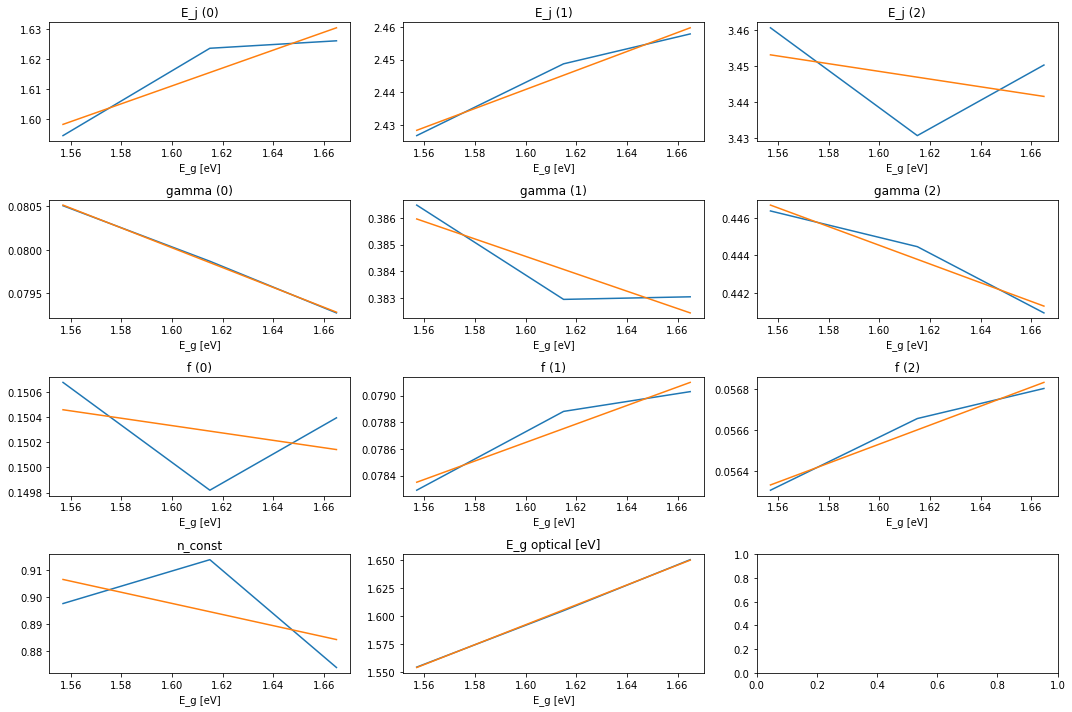

In [8]:
fit_S = np.zeros((N_osc, deg_fitting + 1))
fit_Ec = np.zeros((N_osc, deg_fitting + 1))
fit_W = np.zeros((N_osc, 2))

for i in range(N_osc):
    fit_S[i, :] = np.polyfit(Eg, S[:, i], deg_fitting)
    fit_Ec[i, :] = np.polyfit(Eg, E_c[:, i], deg_fitting)
    fit_W[i, :] = np.polyfit(Eg, W[:, i], deg_fitting)

fit_Emin = np.polyfit(Eg, E_min, deg_fitting)
fit_n_const = np.polyfit(Eg, n_const, deg_fitting)

#Plot the parameters and the obtained fit
if plot_param:
    fig, axs = plt.subplots(4, N_osc, figsize=(15, 10))
    for i in range(N_osc):
        axs[0, i].plot(Eg, E_c[:, i])
        axs[0, i].plot(Eg, np.polyval(fit_Ec[i, :], Eg))
        axs[0, i].set_xlabel('E_g [eV]')
        axs[0, i].set_title('E_j ({})'.format(i))

    for i in range(N_osc):
        axs[1, i].plot(Eg, W[:, i])
        axs[1, i].plot(Eg, np.polyval(fit_W[i, :], Eg))
        axs[1, i].set_xlabel('E_g [eV]')
        axs[1, i].set_title('gamma ({})'.format(i))

    for i in range(N_osc):
        axs[2, i].plot(Eg, S[:, i])
        axs[2, i].plot(Eg, np.polyval(fit_S[i, :], Eg))
        axs[2, i].set_xlabel('E_g [eV]')
        axs[2, i].set_title('f ({})'.format(i))

    axs[3, 0].plot(Eg, n_const)
    axs[3, 0].plot(Eg, np.polyval(fit_n_const, Eg))
    axs[3, 0].set_xlabel('E_g [eV]')
    axs[3, 0].set_title('n_const')

    axs[3, 1].plot(Eg, E_min)
    axs[3, 1].plot(Eg, np.polyval(fit_Emin, Eg))
    axs[3, 1].set_xlabel('E_g [eV]')
    axs[3, 1].set_title('E_g optical [eV]')

    plt.tight_layout()
    plt.show()

### Make the prediction of the refractive index with the desired bandgap energies

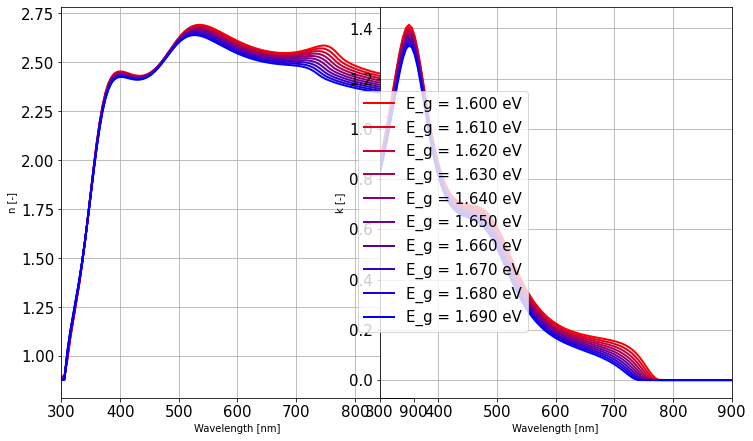

In [9]:
# Define the number of points and colors
n_points = len(wav)
n_colors = len(Eg_wanted)
color_begin = [1, 0, 0]  # Red
color_end = [0, 0, 1]  # Blue
colors = np.linspace(color_begin, color_end, n_colors)

# Create arrays for n_wanted and k_wanted
n_wanted = np.zeros((n_points, n_colors))
k_wanted = np.zeros((n_points, n_colors))

# Create a list to store legend texts
lgd_txt = []

# Create a figure and subplots
fig, (sub1, sub2) = plt.subplots(1, 2)
fig.set_size_inches(12, 6)

# Loop over each desired bandgap energy
for i in range(n_colors):
    # Insert fitting parameters for the current bandgap energy
    S_insert = np.array([np.polyval(fit_S[0, :], Eg_wanted[i]),
                         np.polyval(fit_S[1, :], Eg_wanted[i]),
                         np.polyval(fit_S[2, :], Eg_wanted[i])])
    E_c_insert = np.array([np.polyval(fit_Ec[0, :], Eg_wanted[i]),
                           np.polyval(fit_Ec[1, :], Eg_wanted[i]),
                           np.polyval(fit_Ec[2, :], Eg_wanted[i])])
    W_insert = np.array([np.polyval(fit_W[0, :], Eg_wanted[i]),
                         np.polyval(fit_W[1, :], Eg_wanted[i]),
                         np.polyval(fit_W[2, :], Eg_wanted[i])])
    E_min_insert = np.polyval(fit_Emin, Eg_wanted[i])
    n_c = np.polyval(fit_n_const, Eg_wanted[i])

    # Generate k_E curve for the current bandgap energy
    k_E_fit = Make_k_E_curve(S_insert, E_c_insert, W_insert, E_min_insert, E)

    # Interpolate k_E_fit to get k_wanted
    k_wanted[:, i] = interp1d(E, k_E_fit, kind='linear', fill_value='extrapolate')(h * c / (wav * 1e-9))

    # Calculate n_wanted
    n_wanted[:, i] = KK_integration(wav, k_wanted[:, i]) + n_c

    # Save n_wanted data to CSV file
    df = pd.DataFrame({'nm': wav * 1e-9, 'n': n_wanted[:, i], 'k': np.maximum(k_wanted[:, i], 0)})
    df.to_csv(f'perov_{int(Eg_wanted[i] * 100)}.csv', index=False, sep=';')

    # Plot n_wanted and k_wanted on respective subplots
    sub1.plot(wav, n_wanted[:, i], color=colors[i], linewidth=2)
    sub2.plot(wav, k_wanted[:, i], color=colors[i], linewidth=2)

    # Add legend text
    lgd_txt.append(f'E_g = {Eg_wanted[i]:.3f} eV')

# Set labels and limits for both subplots
for sub in [sub1, sub2]:
    sub.set_xlim([300, 900])
    sub.set_xlabel('Wavelength [nm]')
    sub.grid(True)
sub1.set_ylabel('n [-]')
sub2.set_ylabel('k [-]')

# Adjust font size
for ax in [sub1, sub2]:
    ax.tick_params(axis='both', which='major', labelsize=15)

# Adjust subplot positions
sub1.set_position([sub1.get_position().x0 - 0.06, sub1.get_position().y0 + 0.04,
                   sub1.get_position().width, sub1.get_position().height - 0.04])
sub2.set_position([sub2.get_position().x0 + 0.06, sub2.get_position().y0 + 0.04,
                   sub2.get_position().width, sub2.get_position().height - 0.04])

# Add legend
fig.legend(lgd_txt, loc='center left', bbox_to_anchor=(0.47, 0.5), fontsize=15)
plt.tight_layout()
plt.show()